In [1]:
"""
캘리포니아 주택 데이터를 pandas DataFrame으로 가져옴
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

%matplotlib notebook

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
11886,-121.3,38.0,21.0,1343.0,183.0,462.0,193.0,5.9,189.9
2636,-117.7,33.5,28.0,1261.0,233.0,609.0,242.0,5.1,312.7
15559,-122.3,40.5,16.0,2247.0,502.0,1206.0,463.0,2.0,119.2
641,-117.0,34.0,25.0,3750.0,781.0,1594.0,785.0,2.4,104.9
1333,-117.2,32.8,24.0,3566.0,765.0,1697.0,722.0,3.6,178.6
...,...,...,...,...,...,...,...,...,...
10028,-119.8,36.3,14.0,1287.0,291.0,737.0,269.0,3.2,126.4
13766,-122.0,38.0,34.0,1256.0,267.0,638.0,252.0,4.1,161.0
13664,-122.0,37.5,28.0,3046.0,507.0,1772.0,516.0,5.3,227.9
9114,-119.0,35.4,33.0,821.0,181.0,579.0,172.0,1.2,46.7


In [2]:
"""
입력 함수 설정
"""

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [3]:
"""
모델 학습용 함수 정의
"""


def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Create a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  
  return calibration_data

<IPython.core.display.Javascript object>


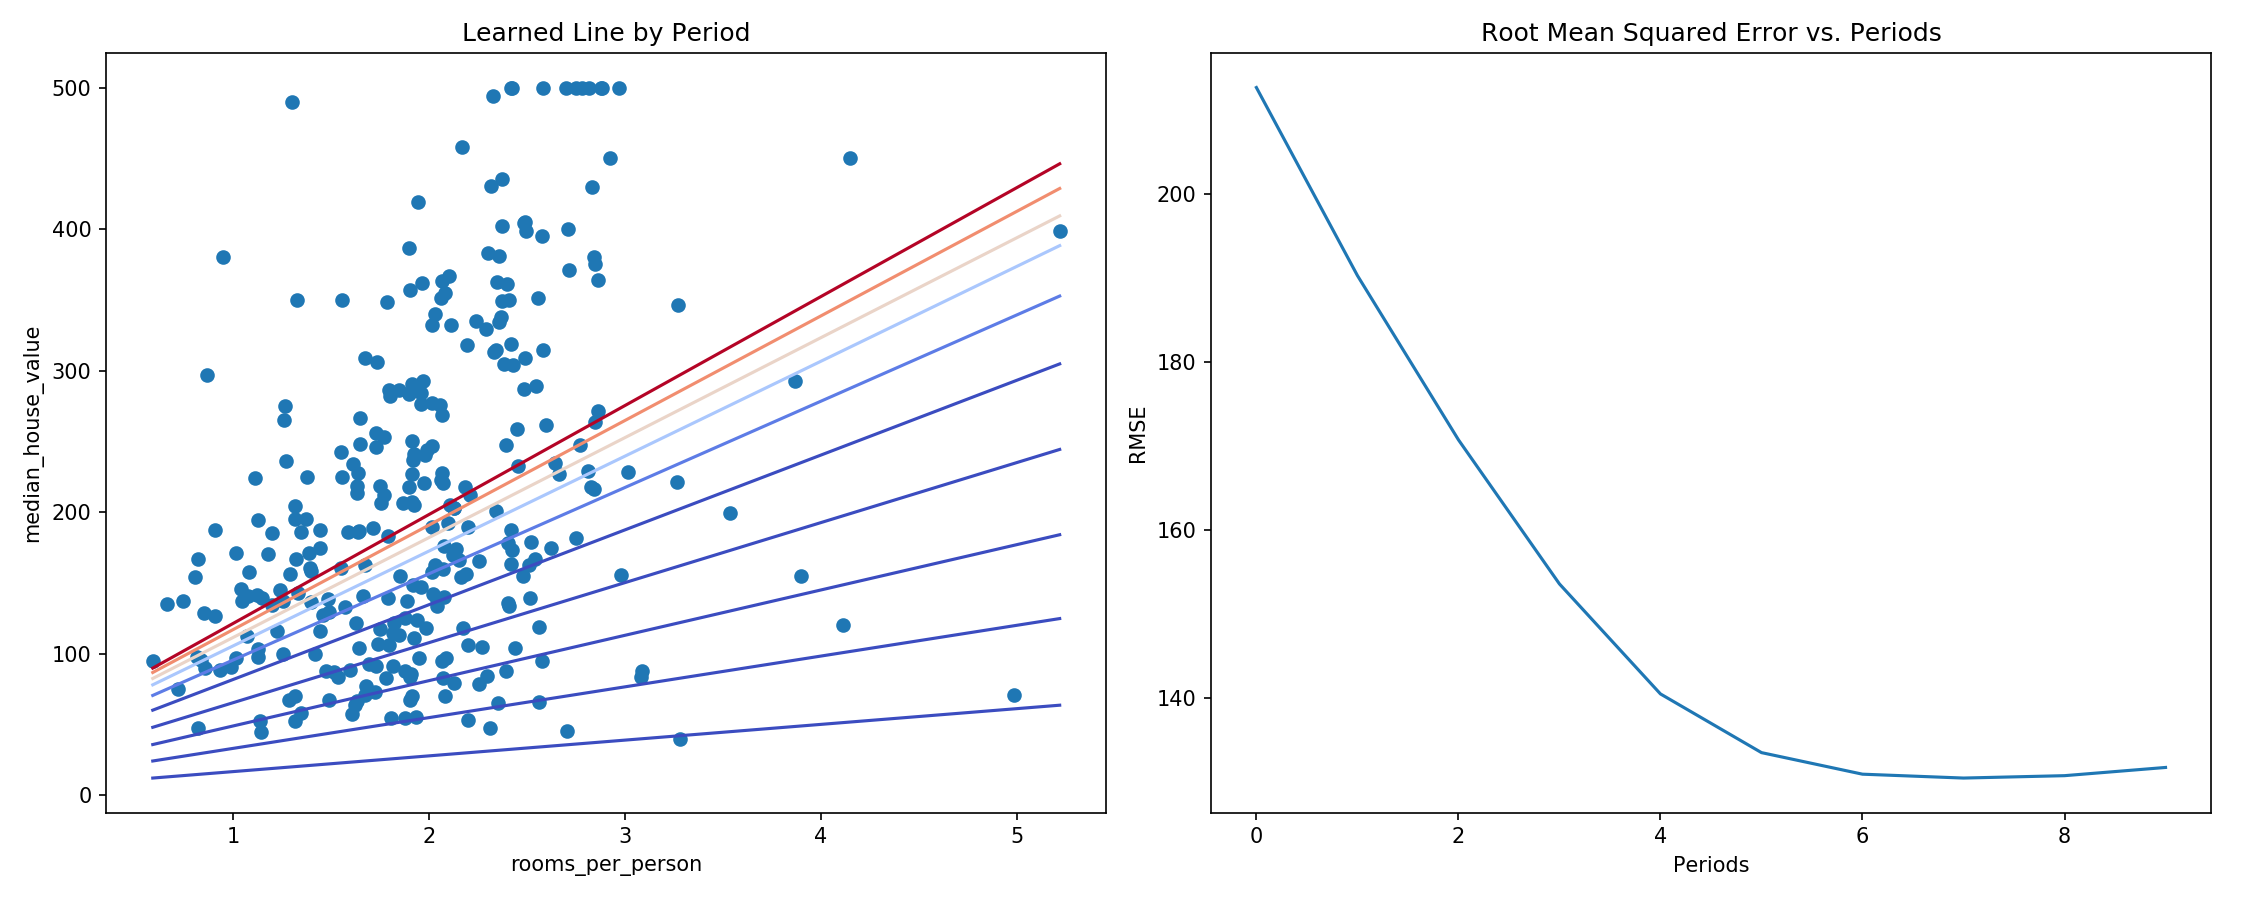

Training model...
RMSE (on training data):
  period 00 : 212.75
  period 01 : 190.34
  period 02 : 170.75
  period 03 : 153.56
  period 04 : 140.45
  period 05 : 133.45
  period 06 : 130.88
  period 07 : 130.42
  period 08 : 130.70
  period 09 : 131.68
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,196.9,207.3
std,90.0,116.0
min,45.8,15.0
25%,161.6,119.4
50%,193.9,180.4
75%,221.3,265.0
max,4295.9,500.0


Final RMSE (on training data): 131.68


In [4]:
# 합성 특성 사용해 보기
"""
total_rooms 특성과 population 특성은 모두 특정 지역의 합계를 계수로 함

그런데 지역마다 인구밀도가 다르다면?

total_rooms와 population의 비율로 합성 특성을 만들면
지역의 인구밀도와 주택 가격 중앙값의 관계를 살펴볼 수 있음

아래 code에서 rooms_per_person이라는 특성을 만들고
train_model()의 input_feature로 사용

학습률을 조정하여 이 단일 특성으로 성능을 어디까지 올릴 수 있을까?
성능이 높다는 것은 회귀선이 데이터에 잘 부합하고 최종 RMSE가 낮다는 의미
"""
# Practice code
"""
california_housing_dataframe["rooms_per_person"] =

calibration_data = train_model(
    learning_rate=0.00005,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)
"""

# An answer

california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")


In [6]:
# 이상점 식별
"""
예측과 목표값을 비교한 산포도를 작성하면 모델의 성능을 시각화할 수 있음
이상적인 상태는 완벽한 상관성을 갖는 대각선(linear regression)이 그려지는 것

위에서 학습한 rooms-per-person 모델을 사용한 예측과
타겟에 대해 Pyplot의 scatter()로 산포도를 작성

특이한 점이 눈에 띄는지 확인해보고 rooms_per_person의 값 분포를 조사하여 소스 데이터를 추적해 봄
"""

# Following codes are an answer of this practice

'\n예측과 목표값을 비교한 산포도를 작성하면 모델의 성능을 시각화할 수 있음\n이상적인 상태는 완벽한 상관성을 갖는 대각선(linear regression)이 그려지는 것\n\n위에서 학습한 rooms-per-person 모델을 사용한 예측과\n타겟에 대해 Pyplot의 scatter()로 산포도를 작성\n\n특이한 점이 눈에 띄는지 확인해보고 rooms_per_person의 값 분포를 조사하여 소스 데이터를 추적해 봄\n'

<IPython.core.display.Javascript object>


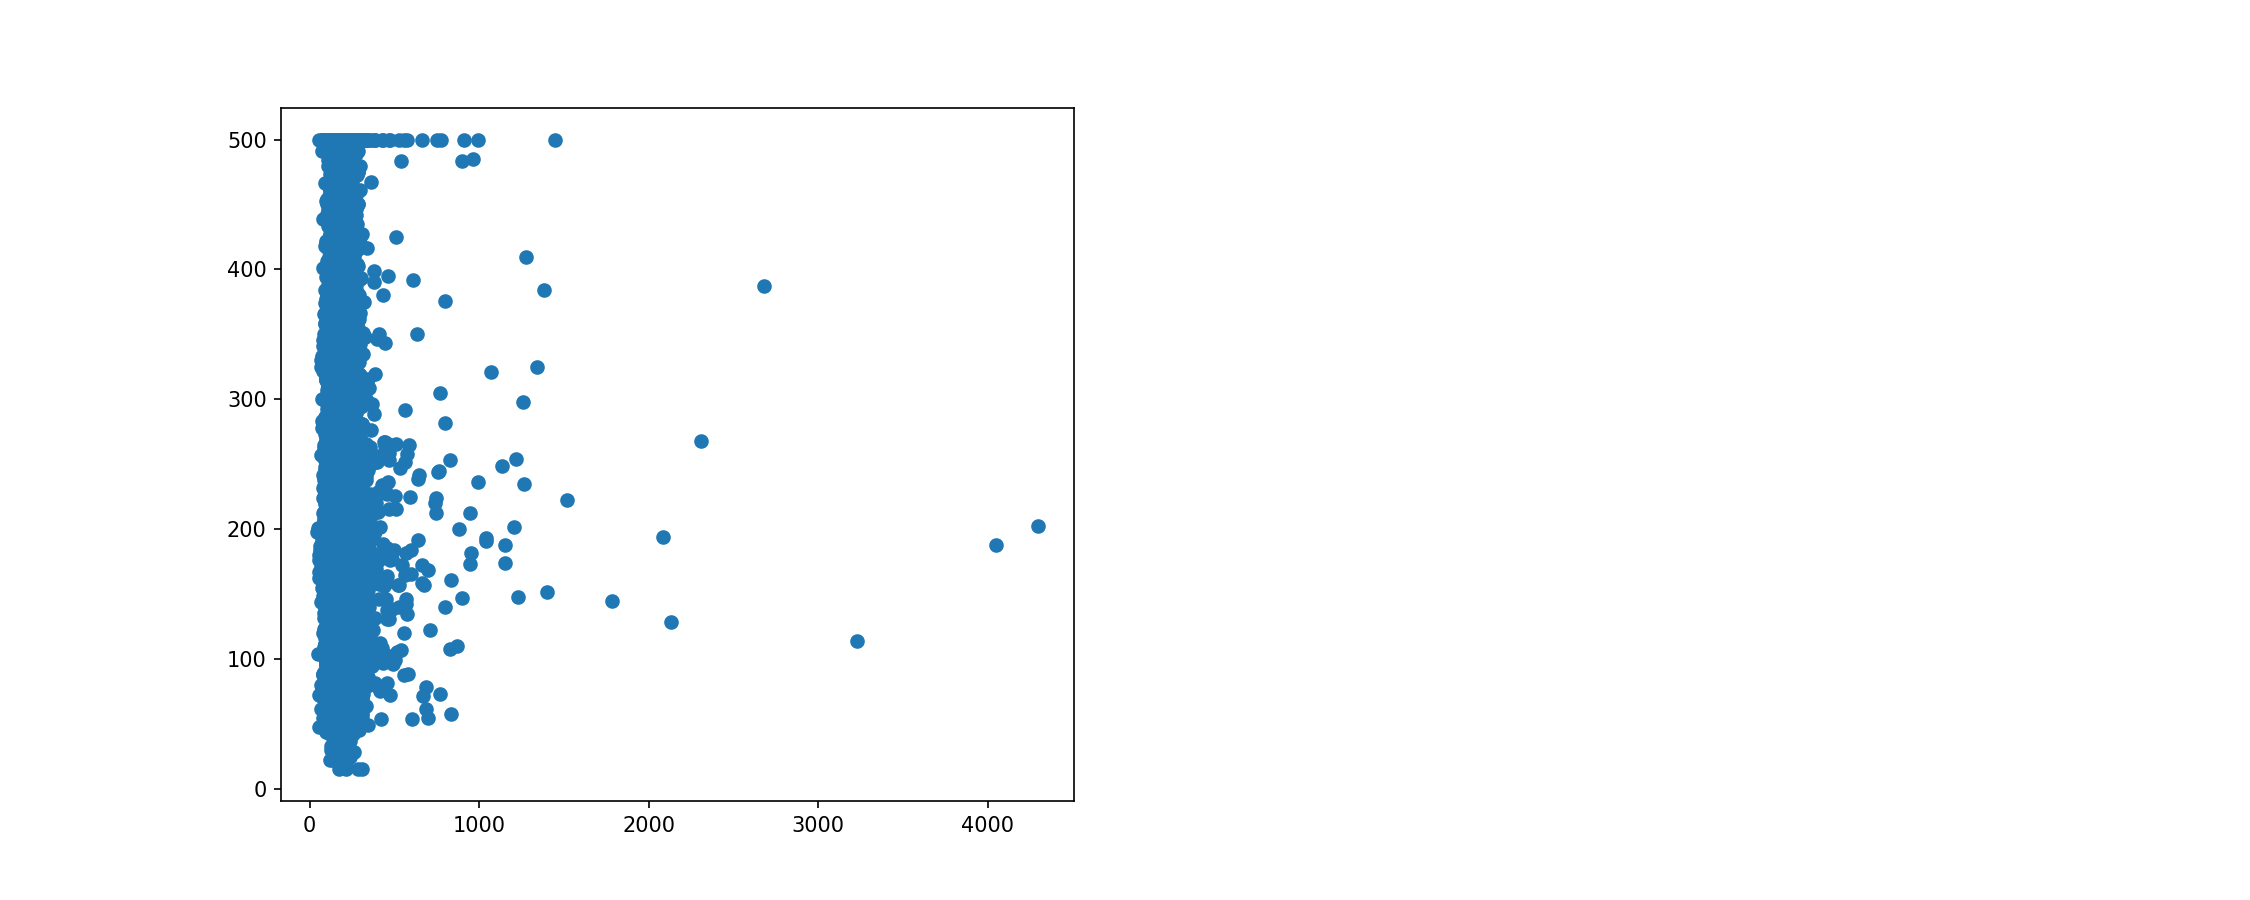

In [5]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

<IPython.core.display.Javascript object>


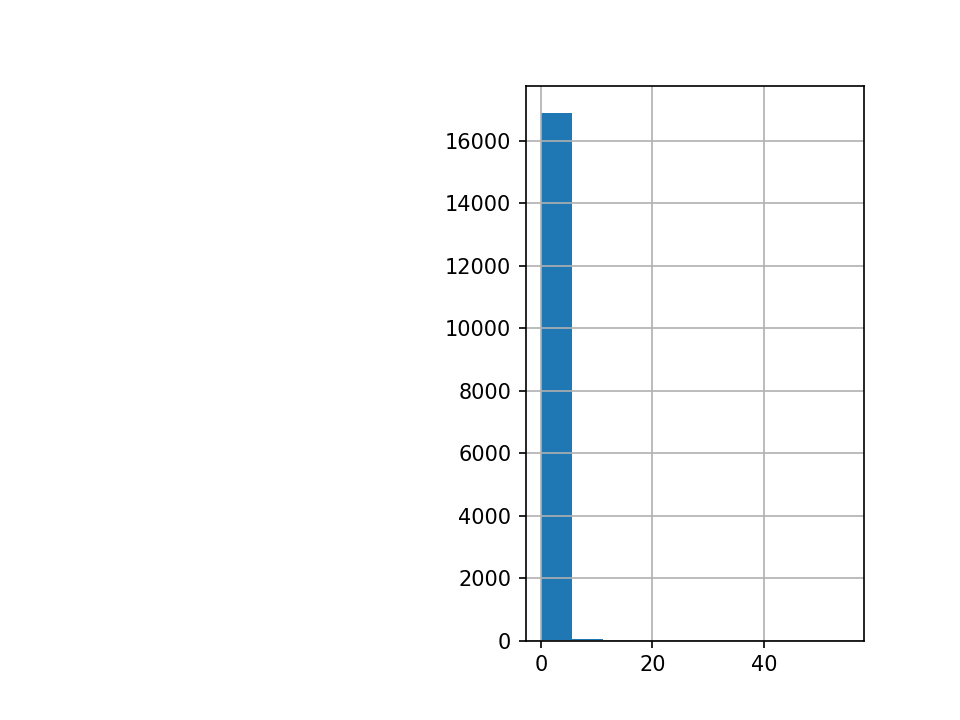

In [6]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

In [7]:
# 이상점 삭제
"""
rooms_per_person의 이상점 값을 적당한 최소값 또는 최대값으로
설정하여 모델의 적합성을 더 높일 수 있는지 확인

다음은 Pandas Series에 함수를 적용하는 방법을 간단히 보여주는 예제

clipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))

위와 같은 clipped_feature는 0 미만의 값을 포함하지 않음
"""

# Following codes are an answer of this practice

'\nrooms_per_person의 이상점 값을 적당한 최소값 또는 최대값으로\n설정하여 모델의 적합성을 더 높일 수 있는지 확인\n\n다음은 Pandas Series에 함수를 적용하는 방법을 간단히 보여주는 예제\n\nclipped_feature = my_dataframe["my_feature_name"].apply(lambda x: max(x, 0))\n\n위와 같은 clipped_feature는 0 미만의 값을 포함하지 않음\n'

<IPython.core.display.Javascript object>


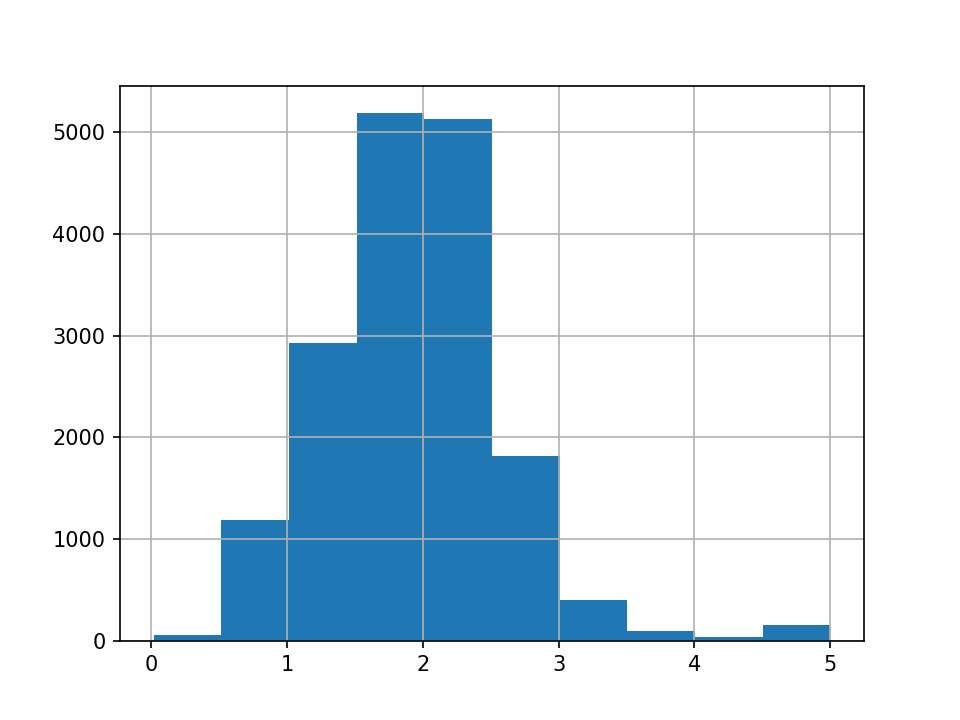

In [8]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

<IPython.core.display.Javascript object>


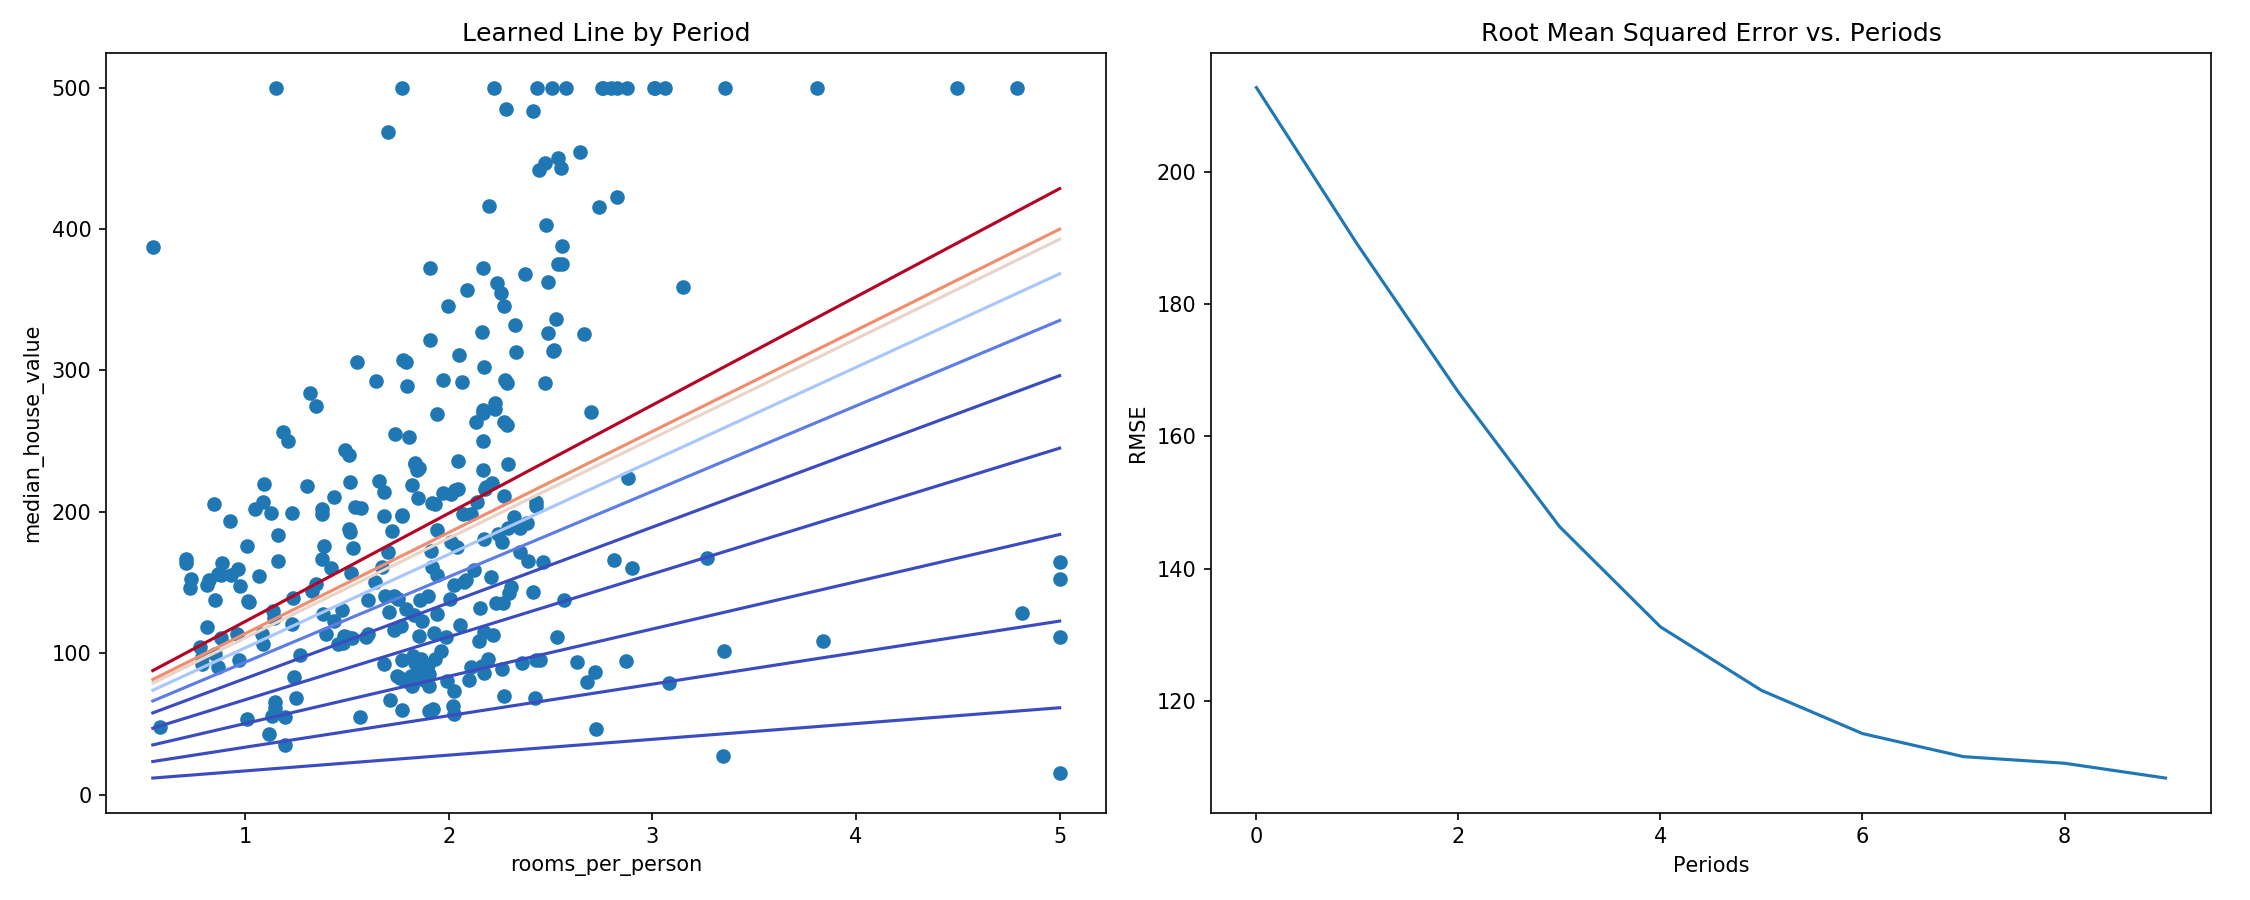

Training model...
RMSE (on training data):
  period 00 : 212.80
  period 01 : 189.05
  period 02 : 166.69
  period 03 : 146.36
  period 04 : 131.18
  period 05 : 121.56
  period 06 : 115.03
  period 07 : 111.53
  period 08 : 110.54
  period 09 : 108.30
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,194.4,207.3
std,50.2,116.0
min,47.2,15.0
25%,162.3,119.4
50%,194.4,180.4
75%,221.7,265.0
max,428.5,500.0


Final RMSE (on training data): 108.30


In [9]:
# 삭제가 효과가 있었는지 확인하기 위해 학습을 다시 실행해 봄

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

<IPython.core.display.Javascript object>


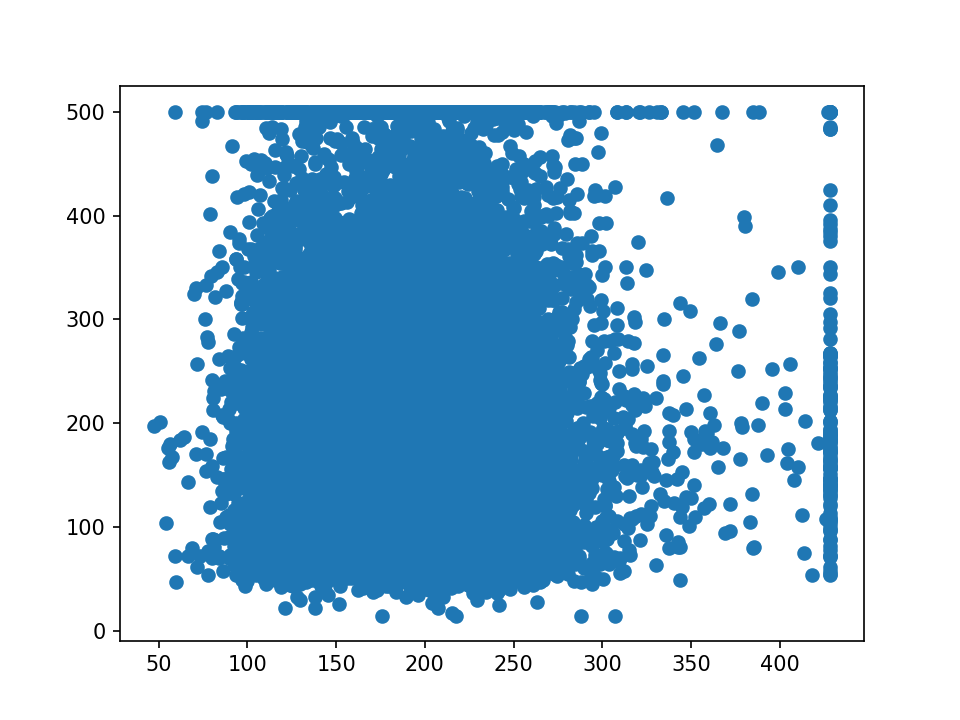

In [10]:
# 보정 데이터를 한 번 더 출력해 봄

_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])